In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb

In [2]:
train = pd.read_csv("../input/train_5clrc8b/train.csv")
test = pd.read_csv("../input/test_jwt0mqh/test.csv")

In [3]:
train.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,02/05/15,11/06/15,16/06/15,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,02/09/15,14/12/15,19/12/15,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


## Lets Check missing values

In [4]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
# Missing values statistics of Customers
missing_values = missing_values_table(train)
missing_values.head(40)

Your selected dataframe has 24 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
state_code_residence,4764,1.4
season_holidayed_code,114,0.0


In [6]:
missing_values = missing_values_table(test)
missing_values.head(40)

Your selected dataframe has 23 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
state_code_residence,2260,1.5
season_holidayed_code,35,0.0


## Lets break down the feature and create baseline

In [7]:
train['booking_date'] = pd.to_datetime(train['booking_date'],format = "%d/%m/%y")
test['booking_date'] = pd.to_datetime(test['booking_date'],format = "%d/%m/%y")

In [8]:
train['booking_date_year'] = train['booking_date'].dt.year
train['booking_date_month'] = train['booking_date'].dt.month
train['booking_date_day_of_year'] = train['booking_date'].dt.dayofyear
train['booking_date_weekday'] = train['booking_date'].dt.weekday
#train['booking_date_week_of_year'] = train['booking_date'].dt.week
train['booking_date_day_of_month'] = train['booking_date'].dt.day
#train['booking_date_quarter'] = train['booking_date'].dt.quarter

test['booking_date_year'] = test['booking_date'].dt.year
test['booking_date_month'] = test['booking_date'].dt.month
test['booking_date_day_of_year'] = test['booking_date'].dt.dayofyear
test['booking_date_weekday'] = test['booking_date'].dt.weekday
#test['booking_date_week_of_year'] = test['booking_date'].dt.week
test['booking_date_day_of_month'] = test['booking_date'].dt.day
#test['booking_date_quarter'] = test['booking_date'].dt.quarter

In [9]:
train['checkin_date'] = pd.to_datetime(train['checkin_date'],format = "%d/%m/%y")
test['checkin_date'] = pd.to_datetime(test['checkin_date'],format = "%d/%m/%y")

In [10]:
train['checkin_date_year'] = train['checkin_date'].dt.year
train['checkin_date_month'] = train['checkin_date'].dt.month
train['checkin_date_day_of_year'] = train['checkin_date'].dt.dayofyear
train['checkin_date_weekday'] = train['checkin_date'].dt.weekday
#train['checkin_date_week_of_year'] = train['checkin_date'].dt.week
train['checkin_date_day_of_month'] = train['checkin_date'].dt.day
#train['checkin_date_quarter'] = train['checkin_date'].dt.quarter

test['checkin_date_year'] = test['checkin_date'].dt.year
test['checkin_date_month'] = test['checkin_date'].dt.month
test['checkin_date_day_of_year'] = test['checkin_date'].dt.dayofyear
test['checkin_date_weekday'] = test['checkin_date'].dt.weekday
#test['checkin_date_week_of_year'] = test['checkin_date'].dt.week
test['checkin_date_day_of_month'] = test['checkin_date'].dt.day
#test['checkin_date_quarter'] = test['checkin_date'].dt.quarter

In [11]:
train['checkout_date'] = pd.to_datetime(train['checkout_date'],format = "%d/%m/%y")
test['checkout_date'] = pd.to_datetime(test['checkout_date'],format = "%d/%m/%y")

In [12]:
train['checkout_date_year'] = train['checkout_date'].dt.year
train['checkout_date_month'] = train['checkout_date'].dt.month
train['checkout_date_day_of_year'] = train['checkout_date'].dt.dayofyear
train['checkout_date_weekday'] = train['checkout_date'].dt.weekday
#train['checkout_date_week_of_year'] = train['checkout_date'].dt.week
train['checkout_date_day_of_month'] = train['checkout_date'].dt.day
#train['checkout_date_quarter'] = train['checkout_date'].dt.quarter

test['checkout_date_year'] = test['checkout_date'].dt.year
test['checkout_date_month'] = test['checkout_date'].dt.month
test['checkout_date_day_of_year'] = test['checkout_date'].dt.dayofyear
test['checkout_date_weekday'] = test['checkout_date'].dt.weekday
#test['checkout_date_week_of_year'] = test['checkout_date'].dt.week
test['checkout_date_day_of_month'] = test['checkout_date'].dt.day
#test['checkout_date_quarter'] = test['checkout_date'].dt.quarter

## Additional Features

In [13]:
# Find if check in is done on weekend 

train['Checkin_date_is_week_end'] = train['checkin_date_weekday'].apply(lambda x:1 if x >= 5 else 0)
test['Checkin_date_is_week_end'] = test['checkin_date_weekday'].apply(lambda x:1 if x >= 5 else 0)

In [14]:
train['channel_code']=train['channel_code'].astype(object)
test['channel_code']=test['channel_code'].astype(object)

In [15]:
train['main_product_code']=train['main_product_code'].astype(object)
test['main_product_code']=test['main_product_code'].astype(object)

In [16]:
train['persontravellingid']=train['persontravellingid'].astype(object)
test['persontravellingid']=test['persontravellingid'].astype(object)

In [17]:
train['resort_region_code']=train['resort_region_code'].astype(object)
test['resort_region_code']=test['resort_region_code'].astype(object)

In [18]:
train['room_type_booked_code']=train['room_type_booked_code'].astype(object)
test['room_type_booked_code']=test['room_type_booked_code'].astype(object)

In [19]:
train['state_code_residence'] = train['state_code_residence'].fillna(0.0)
test['state_code_residence'] = test['state_code_residence'].fillna(0.0)

train['season_holidayed_code'] = train['season_holidayed_code'].fillna(0.0)
test['season_holidayed_code'] = test['season_holidayed_code'].fillna(0.0)

In [20]:
train['season_holidayed_code']=train['season_holidayed_code'].astype(object)
test['season_holidayed_code']=test['season_holidayed_code'].astype(object)

In [21]:
train['state_code_residence']=train['state_code_residence'].astype(object)
test['state_code_residence']=test['state_code_residence'].astype(object)

In [22]:
train['state_code_resort']=train['state_code_resort'].astype(object)
test['state_code_resort']=test['state_code_resort'].astype(object)

In [23]:
train['member_age_buckets']=train['member_age_buckets'].astype(object)
test['member_age_buckets']=test['member_age_buckets'].astype(object)

In [24]:
train['booking_type_code']=train['booking_type_code'].astype(object)
test['booking_type_code']=test['booking_type_code'].astype(object)

In [25]:
train['cluster_code']=train['cluster_code'].astype(object)
test['cluster_code']=test['cluster_code'].astype(object)

In [26]:
train['reservationstatusid_code']=train['reservationstatusid_code'].astype(object)
test['reservationstatusid_code']=test['reservationstatusid_code'].astype(object)

In [27]:
train['resort_id']=train['resort_id'].astype(object)
test['resort_id']=test['resort_id'].astype(object)

In [28]:
train['resort_type_code']=train['resort_type_code'].astype(object)
test['resort_type_code']=test['resort_type_code'].astype(object)

## Feature Engg

In [29]:
train['Advance_Booking_Days'] = train['checkin_date'] - train['booking_date']
test['Advance_Booking_Days'] = test['checkin_date'] - test['booking_date']

In [30]:
train['Advance_Booking_Days']=train['Advance_Booking_Days']/np.timedelta64(1,'D')
test['Advance_Booking_Days']=test['Advance_Booking_Days']/np.timedelta64(1,'D')

In [31]:
train['Advance_Booking_Days'][train['Advance_Booking_Days']<-300] = 0
test['Advance_Booking_Days'][test['Advance_Booking_Days']<-300] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
train['total_person'] = train['numberofadults'] + train['numberofchildren']
test['total_person'] = test['numberofadults'] + test['numberofchildren']

## Combine Features

In [33]:
train['main_product_code']=train['main_product_code'].astype(str)
test['main_product_code']=test['main_product_code'].astype(str)

train['channel_code']=train['channel_code'].astype(str)
test['channel_code']=test['channel_code'].astype(str)

train['NewType1'] = train['main_product_code'] + train['channel_code']
test['NewType1'] = test['main_product_code'] + test['channel_code']

train['main_product_code']=train['main_product_code'].astype(object)
test['main_product_code']=test['main_product_code'].astype(object)

train['channel_code']=train['channel_code'].astype(object)
test['channel_code']=test['channel_code'].astype(object)

train['NewType1']=train['NewType1'].astype(object)
test['NewType1']=test['NewType1'].astype(object)

In [34]:
# No of nights 
train['No_of_days'] = (train['checkout_date'] - train['checkin_date']).dt.days
test['No_of_days'] = (test['checkout_date'] - test['checkin_date']).dt.days

In [35]:
train['Product_usedby_adults'] = train.groupby(['main_product_code'])['numberofadults'].transform('mean')
test['Product_usedby_adults'] = test.groupby(['main_product_code'])['numberofadults'].transform('mean')

train['Product_usedby_child'] = train.groupby(['main_product_code'])['numberofadults'].transform('mean')
test['Product_usedby_child'] = test.groupby(['main_product_code'])['numberofadults'].transform('mean')



train['memberid_by_adult'] = train.groupby(['memberid'])['numberofadults'].transform('mean')
test['memberid_by_adult'] = test.groupby(['memberid'])['numberofadults'].transform('mean')

train['memberid_by_adult_sum'] = train.groupby(['memberid'])['numberofadults'].transform('sum')
test['memberid_by_adult_sum'] = test.groupby(['memberid'])['numberofadults'].transform('sum')


train['memberid_by_room_night_sum'] = train.groupby(['memberid'])['roomnights'].transform('sum')
test['memberid_by_room_night_sum'] = test.groupby(['memberid'])['roomnights'].transform('sum')

train['memberid_by_child'] = train.groupby(['memberid'])['numberofchildren'].transform('mean')
test['memberid_by_child'] = test.groupby(['memberid'])['numberofchildren'].transform('mean')


train['persontravellingid_by_adult_sum'] = train.groupby(['persontravellingid'])['numberofadults'].transform('sum')
test['persontravellingid_by_adult_sum'] = test.groupby(['persontravellingid'])['numberofadults'].transform('sum')


train['persontravellingid_by_totalpax'] = train.groupby(['persontravellingid'])['total_pax'].transform('mean')
test['persontravellingid_by_totalpax'] = test.groupby(['persontravellingid'])['total_pax'].transform('mean')

train['persontravellingid_by_room_night_mean'] = train.groupby(['persontravellingid'])['No_of_days'].transform('mean')
test['persontravellingid_by_room_night_mean'] = test.groupby(['persontravellingid'])['No_of_days'].transform('mean')

train['persontravellingid_by_adult_mean'] = train.groupby(['persontravellingid'])['numberofadults'].transform('mean')
test['persontravellingid_by_adult_mean'] = test.groupby(['persontravellingid'])['numberofadults'].transform('mean')

train['season_holidayed_code_by_adult_mean'] = train.groupby(['season_holidayed_code'])['numberofadults'].transform('mean')
test['season_holidayed_code_by_adult_mean'] = test.groupby(['season_holidayed_code'])['numberofadults'].transform('mean')

In [36]:
train['Diff_person'] = train['total_person'] - train['total_pax']
test['Diff_person'] = test['total_person'] - test['total_pax']

In [37]:
train['person_ratio'] = train['total_pax'] / train['total_person']
test['person_ratio'] = test['total_pax'] / test['total_person']

In [38]:
train['memberid'].value_counts()
train = train.drop(['reservation_id','booking_date','memberid','checkin_date','checkout_date'],axis=1)
test = test.drop(['reservation_id','booking_date','memberid','checkin_date','checkout_date'],axis=1)

In [39]:
import gc
gc.collect()

157

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341424 entries, 0 to 341423
Data columns (total 52 columns):
channel_code                             341424 non-null object
main_product_code                        341424 non-null object
numberofadults                           341424 non-null int64
numberofchildren                         341424 non-null int64
persontravellingid                       341424 non-null object
resort_region_code                       341424 non-null object
resort_type_code                         341424 non-null object
room_type_booked_code                    341424 non-null object
roomnights                               341424 non-null int64
season_holidayed_code                    341424 non-null object
state_code_residence                     341424 non-null object
state_code_resort                        341424 non-null object
total_pax                                341424 non-null int64
member_age_buckets                       341424 non-null obje

In [41]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [42]:
# Align train and test

train_labels = train['amount_spent_per_room_night_scaled']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['amount_spent_per_room_night_scaled'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (341424, 188)
Testing Features shape:  (146765, 187)


In [43]:
train = train.reindex(
    np.random.permutation(train.index))

In [44]:
y = train['amount_spent_per_room_night_scaled']
X = train.drop('amount_spent_per_room_night_scaled',axis=1)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Light GBM

In [47]:
def run_lgb(X_train, X_test, y_train, y_test, test_df):
    params = {
        "objective" : "regression_l2",
       "n_estimators":10000,
        "learning_rate" :0.01,
        "num_leaves" :128,
        "min_data_in_leaf":350,
        'max_bin':350,
        'max_depth':4,
        "metric" : "rmse",
        "reg_alpha" :0.2,
        "reg_lambda":0.2,
        'feature_fraction':0.99,
        'min_gain_to_split':0.1,
        'bagging_fraction':0.99,
        'min_data_per_group':100,
        'max_cat_threshold':40,
        'cat_l2':10,
        'cat_smooth':15,
        'max_cat_to_onehot':6
        
    }
    
    lgtrain = lgb.Dataset(X_train, label=y_train)
    lgval = lgb.Dataset(X_test, label=y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=50, 
                      verbose_eval=50, 
                      evals_result=evals_result)
    
    pred_test_y = model.predict(test_df, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [48]:
pred_test, model, evals_result = run_lgb(X_train, X_test, y_train, y_test, test)
print("LightGBM Training Completed...")

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 1.05191	valid_1's rmse: 1.04721
[100]	training's rmse: 1.03287	valid_1's rmse: 1.02817
[150]	training's rmse: 1.02117	valid_1's rmse: 1.01675
[200]	training's rmse: 1.01325	valid_1's rmse: 1.00893
[250]	training's rmse: 1.00749	valid_1's rmse: 1.00323
[300]	training's rmse: 1.00301	valid_1's rmse: 0.998808
[350]	training's rmse: 0.999442	valid_1's rmse: 0.995318
[400]	training's rmse: 0.996559	valid_1's rmse: 0.992533
[450]	training's rmse: 0.994106	valid_1's rmse: 0.990172
[500]	training's rmse: 0.992098	valid_1's rmse: 0.988282
[550]	training's rmse: 0.990317	valid_1's rmse: 0.986642
[600]	training's rmse: 0.988813	valid_1's rmse: 0.985283
[650]	training's rmse: 0.987476	valid_1's rmse: 0.984058
[700]	training's rmse: 0.986318	valid_1's rmse: 0.983005
[750]	training's rmse: 0.985287	valid_1's rmse: 0.98206
[800]	training's rmse: 0.984373	valid_1's rmse: 0.981234
[850]	training's rmse: 0.983546	valid_1

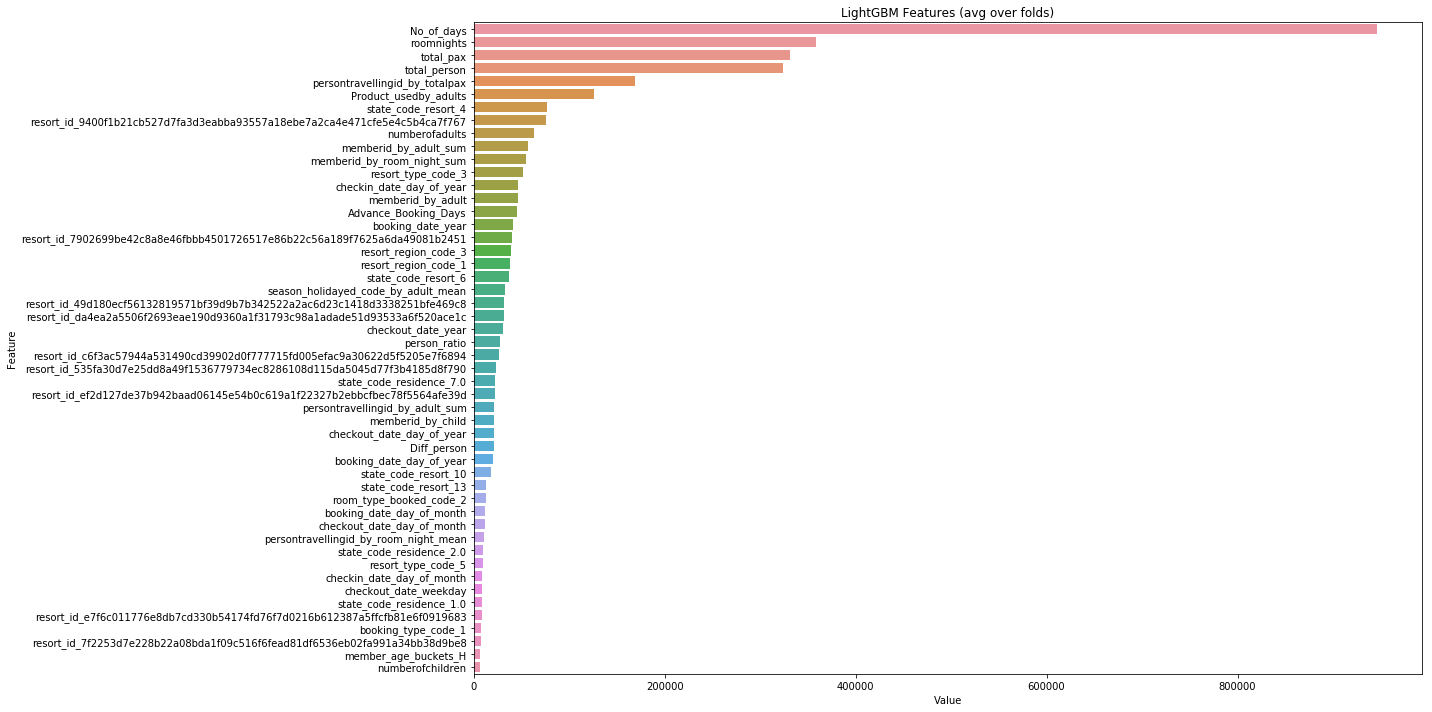

In [49]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X_train.columns)), columns=['Value','Feature'])
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(50))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()


In [50]:
sub = pd.read_csv('../input/sample_submission_dlc0jkw/sample_submission.csv')
sub['amount_spent_per_room_night_scaled'] = pred_test
sub.to_csv('LGB_Sub_Final_1.csv',index=False)

## XG Booster

In [51]:
import xgboost
import xgboost as xgb

In [52]:
def run_xgb(X_train, X_test, y_train, y_test, test_df_lgb):
    params = {'objective': 'reg:linear', 
              'booster' : "gbtree",
              'eval_metric':'rmse',
              'eta': 0.04,
              'max_depth': 4, 
              'subsample': 0.9500000000000001, #changed from 0.6
              'colsample_bytree': 0.99,
              'lambda':0.3,
              'gamma':0.6,
              #'alpha':0.001,
              'random_state': 42,
              'max_bin':450, #changed from 450
              'grow_policy':'lossguide',
              'max_leaves':150,
              'silent': True}
    
    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_test, y_test)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 10, verbose_eval=10)
    
    #cv = xgb.cv(params, tr_data, 271, nfold=5, early_stopping_rounds=10, verbose_eval=10)
    
    dtest = xgb.DMatrix(test_df_lgb)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_y, model_xgb

In [53]:
# Training XGB
pred_test_xgb, model_xgb = run_xgb(X_train, X_test, y_train, y_test, test)
print("XGB Training Completed...")

[0]	train-rmse:7.01657	valid-rmse:7.01604
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:4.72771	valid-rmse:4.72692
[20]	train-rmse:3.23499	valid-rmse:3.23368
[30]	train-rmse:2.28105	valid-rmse:2.27934
[40]	train-rmse:1.69438	valid-rmse:1.69218
[50]	train-rmse:1.35483	valid-rmse:1.352
[60]	train-rmse:1.17211	valid-rmse:1.16885
[70]	train-rmse:1.08002	valid-rmse:1.07645
[80]	train-rmse:1.03516	valid-rmse:1.03148
[90]	train-rmse:1.01355	valid-rmse:1.00979
[100]	train-rmse:1.00263	valid-rmse:0.998941
[110]	train-rmse:0.996967	valid-rmse:0.993331
[120]	train-rmse:0.993497	valid-rmse:0.989988
[130]	train-rmse:0.991198	valid-rmse:0.987791
[140]	train-rmse:0.989489	valid-rmse:0.986245
[150]	train-rmse:0.988097	valid-rmse:0.984971
[160]	train-rmse:0.986968	valid-rmse:0.983974
[170]	train-rmse:0.985911	valid-rmse:0.983124
[180]	train-rmse:0.98494	valid-rmse:0.982283
[190]	train-rmse

In [54]:
sub = pd.read_csv('../input/sample_submission_dlc0jkw/sample_submission.csv')
sub['amount_spent_per_room_night_scaled'] = pred_test_xgb
sub.to_csv('XGB_Sub_Final_1.csv',index=False)

## CatBooster

In [55]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

In [56]:
cb_model = CatBoostRegressor(iterations=5000,
                             learning_rate=0.03,
                             depth=4,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             l2_leaf_reg = 0.5,
                             od_wait=100)
cb_model.fit(X_train, y_train,
             eval_set=(X_test,y_test),
             use_best_model=True,
             verbose=True)

0:	learn: 7.5681124	test: 7.5676388	best: 7.5676388 (0)	total: 173ms	remaining: 14m 25s
1:	learn: 7.3458541	test: 7.3453712	best: 7.3453712 (1)	total: 296ms	remaining: 12m 19s
2:	learn: 7.1303219	test: 7.1298083	best: 7.1298083 (2)	total: 400ms	remaining: 11m 6s
3:	learn: 6.9214649	test: 6.9209301	best: 6.9209301 (3)	total: 516ms	remaining: 10m 44s
4:	learn: 6.7190219	test: 6.7184854	best: 6.7184854 (4)	total: 620ms	remaining: 10m 19s
5:	learn: 6.5227295	test: 6.5221695	best: 6.5221695 (5)	total: 727ms	remaining: 10m 5s
6:	learn: 6.3325062	test: 6.3319209	best: 6.3319209 (6)	total: 829ms	remaining: 9m 51s
7:	learn: 6.1482187	test: 6.1476218	best: 6.1476218 (7)	total: 937ms	remaining: 9m 44s
8:	learn: 5.9696324	test: 5.9690238	best: 5.9690238 (8)	total: 1.03s	remaining: 9m 33s
9:	learn: 5.7965459	test: 5.7959208	best: 5.7959208 (9)	total: 1.15s	remaining: 9m 33s
10:	learn: 5.6288601	test: 5.6282001	best: 5.6282001 (10)	total: 1.24s	remaining: 9m 22s
11:	learn: 5.4663364	test: 5.4656592	

In [57]:
cat_predict = cb_model.predict(test)

In [58]:
sub = pd.read_csv('../input/sample_submission_dlc0jkw/sample_submission.csv')
sub['amount_spent_per_room_night_scaled'] = cat_predict
sub.to_csv('CAT_Sub_Final_1.csv',index=False)

In [59]:
sub = pd.read_csv('../input/sample_submission_dlc0jkw/sample_submission.csv')

In [60]:
sub.head()

,reservation_id,amount_spent_per_room_night_scaled
0,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d...,8
1,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb...,8
2,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e...,8
3,09593c907ae262e46f655b4db9e14f54a19eadcfdd2679...,8
4,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1...,8


In [61]:
avg = (pred_test * 0.5) + (pred_test_xgb * 0.5 )

In [62]:
sub['amount_spent_per_room_night_scaled'] = avg

In [63]:
sub.to_csv('Sub_Final_ENS_1.csv',index=False)